## Group Members: Muhammad Salman & Shahid Ullah
## Roll No.: 22I-2027 & 22I-2019
# --------------------------------------------------------

# For urlset.csv Dataset 

# 1. Libaries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tldextract
import whois
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [3]:
df = pd.read_csv("urlset.csv", encoding="latin1", on_bad_lines="skip")
print("Dataset Shape:", df.shape)
print(df.columns)

Dataset Shape: (96005, 14)
Index(['domain', 'ranking', 'mld_res', 'mld.ps_res', 'card_rem', 'ratio_Rrem',
       'ratio_Arem', 'jaccard_RR', 'jaccard_RA', 'jaccard_AR', 'jaccard_AA',
       'jaccard_ARrd', 'jaccard_ARrem', 'label'],
      dtype='object')


C:\Users\SK Khan\AppData\Local\Temp\ipykernel_11676\362355659.py:1: DtypeWarning: Columns (1,2,3,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("urlset.csv", encoding="latin1", on_bad_lines="skip")


# 2. Data Preprocessing and Feature Selection & Extraction

In [4]:
#Removal of null values & duplicates
df = df.dropna()                 
df = df.drop_duplicates()        
df = df.reset_index(drop=True)
print("After Null & Duplicate Removal:", df.shape)

#Feature Selection & Extraction
# We'll use domain to extract lexical features
def extract_features(domain):
    features = {}
    features['url_len'] = len(domain)
    features['dot_count'] = domain.count('.')
    features['digit_count'] = sum(c.isdigit() for c in domain)
    features['special_count'] = len(re.findall(r'[@_!#$%^&*()<>?/\|}{~:]', domain))
    features['hyphen_count'] = domain.count('-')
    features['double_slash'] = domain.count('//')
    features['single_slash'] = domain.count('/')
    features['at_count'] = domain.count('@')
    features['protocol_count'] = 1 if domain.startswith("https") else 0
    
    # WHOIS (here we put -1 placeholder, actual lookup can be added if internet allowed)
    features['whois_reg_age'] = 0
    features['whois_exp_age'] = 0
    return features

feature_list = df['domain'].apply(extract_features)
X = pd.DataFrame(feature_list.tolist())

# Add original numeric columns too (except domain and label)
other_features = df.drop(columns=['domain','label'])
X = pd.concat([X, other_features.reset_index(drop=True)], axis=1)


if df['label'].dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(df['label'])
else:
    y = df['label'].values

#Balanced Undersampling
from sklearn.utils import resample

df_bal = pd.concat([X, pd.Series(y, name="label")], axis=1)

count_class_0, count_class_1 = df_bal['label'].value_counts()

if abs(count_class_0 - count_class_1) > 0:  
    df_class_0 = df_bal[df_bal['label'] == 0]
    df_class_1 = df_bal[df_bal['label'] == 1]

    # undersample the larger class
    if count_class_0 > count_class_1:
        df_class_0_under = resample(df_class_0,
                                    replace=False,
                                    n_samples=count_class_1,
                                    random_state=42)
        df_bal = pd.concat([df_class_0_under, df_class_1])
    else:
        df_class_1_under = resample(df_class_1,
                                    replace=False,
                                    n_samples=count_class_0,
                                    random_state=42)
        df_bal = pd.concat([df_class_1_under, df_class_0])

df_bal = df_bal.sample(frac=1, random_state=42).reset_index(drop=True) 
print("After Balancing:", df_bal.shape)

# Final features & labels
X_final = df_bal.drop(columns=["label"])
y_final = df_bal["label"]

print("Final Feature Shape:", X_final.shape)
print("Final Label Distribution:\n", y_final.value_counts())


After Null & Duplicate Removal: (95912, 14)
After Balancing: (95806, 24)
Final Feature Shape: (95806, 23)
Final Label Distribution:
 label
0.0    47903
1.0    47903
Name: count, dtype: int64


# 3. Train-Test Split

In [5]:
# Ensure all features are numeric
X_final = X_final.apply(pd.to_numeric, errors='coerce')
X_final = X_final.fillna(X_final.median())

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

# Scale features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train Shape:", X_train.shape, "Test Shape:", X_test.shape)


Train Shape: (76644, 23) Test Shape: (19162, 23)


# 4. Train Models and Evaluation

In [6]:
from sklearn.dummy import DummyClassifier

# Models Dictionary
models = {
    "Decision Tree": DecisionTreeClassifier(criterion="entropy", random_state=0),
    "Random Forest": RandomForestClassifier(n_estimators=20, criterion="entropy", random_state=0),
    "SVM": SVC(kernel="rbf", C=10, gamma=1, probability=True, random_state=0),
    "Random Baseline": DummyClassifier(strategy="uniform", random_state=0)  # Added
}

results = {}

# Training & Evaluation
for name, model in models.items():
    start = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start
    
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        "Accuracy": acc, 
        "Precision": prec, 
        "Recall": rec, 
        "F1": f1, 
        "Train Time (s)": train_time
    }
    
    print(f"\n{name} Results:")
    print("Accuracy:", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall:", round(rec, 4))
    print("F1 Score:", round(f1, 4))
    print("Training Time (s):", round(train_time, 4))

# Results Table
results_df = pd.DataFrame(results).T
print("\nFinal Results Table:\n")
results_df



Decision Tree Results:
Accuracy: 0.9303
Precision: 0.9279
Recall: 0.9331
F1 Score: 0.9305
Training Time (s): 0.8126

Random Forest Results:
Accuracy: 0.9521
Precision: 0.961
Recall: 0.9425
F1 Score: 0.9517
Training Time (s): 2.657

SVM Results:
Accuracy: 0.9367
Precision: 0.9396
Recall: 0.9334
F1 Score: 0.9365
Training Time (s): 5059.7508

Random Baseline Results:
Accuracy: 0.5002
Precision: 0.5002
Recall: 0.5042
F1 Score: 0.5022
Training Time (s): 0.0027

Final Results Table:



,Accuracy,Precision,Recall,F1,Train Time (s)
Decision Tree,0.930279,0.927867,0.933097,0.930475,0.812612
Random Forest,0.952145,0.961047,0.942490,0.951678,2.657012
SVM,0.936698,0.939588,0.933410,0.936489,5059.750787
Random Baseline,0.500209,0.500207,0.504227,0.502209,0.002737


# 5. Graphs and Confusion Matrices

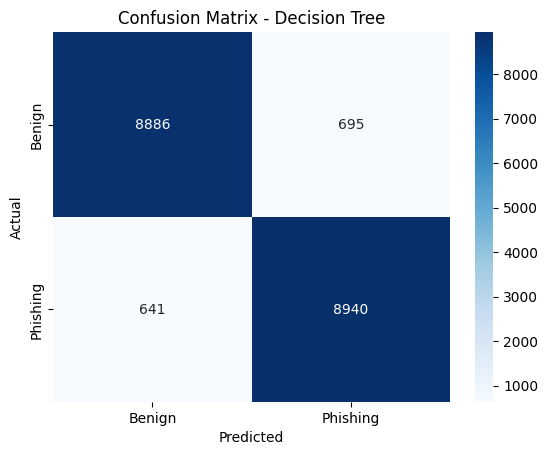

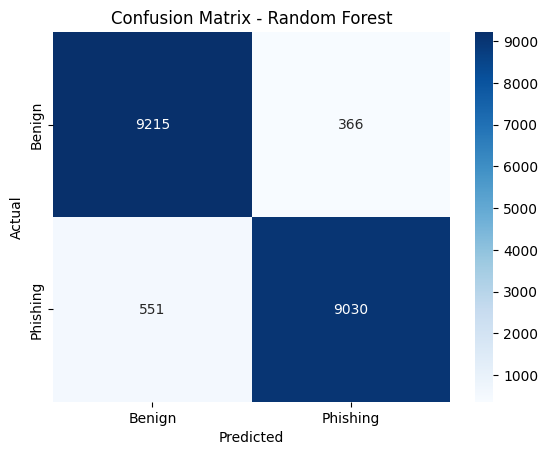

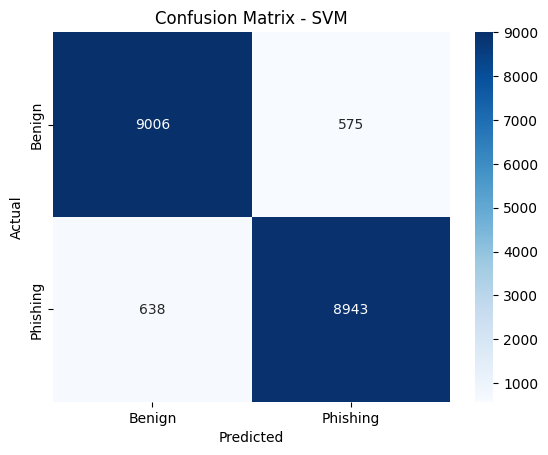

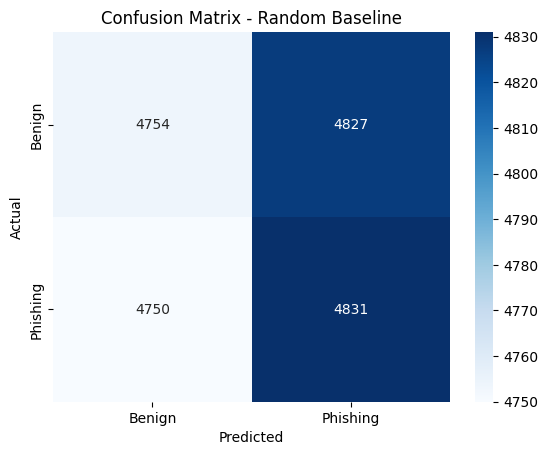

In [7]:
# Confusion Matrices
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign","Phishing"], yticklabels=["Benign","Phishing"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

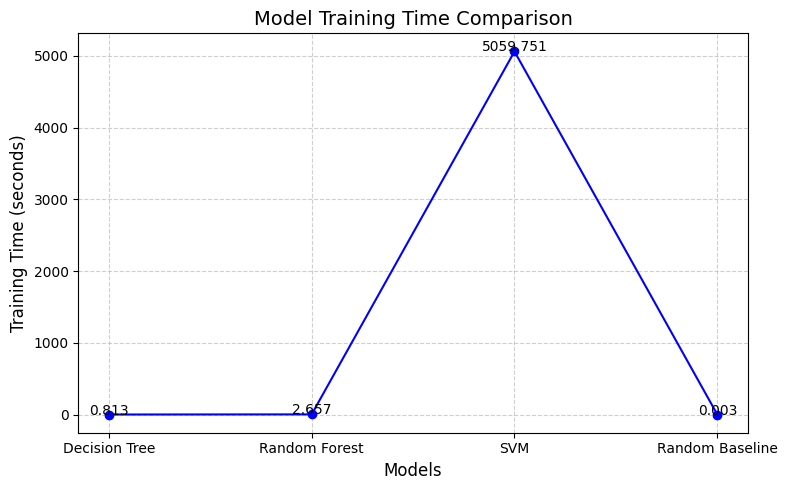

In [8]:
import matplotlib.pyplot as plt

# Extract training times
train_times = results_df["Train Time (s)"]

plt.figure(figsize=(8,5))
plt.plot(train_times.index, train_times.values, marker='o', linestyle='-', color='b')

plt.title("Model Training Time Comparison", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Training Time (seconds)", fontsize=12)

for i, v in enumerate(train_times.values):
    plt.text(i, v + 0.001, f"{v:.3f}", ha='center', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


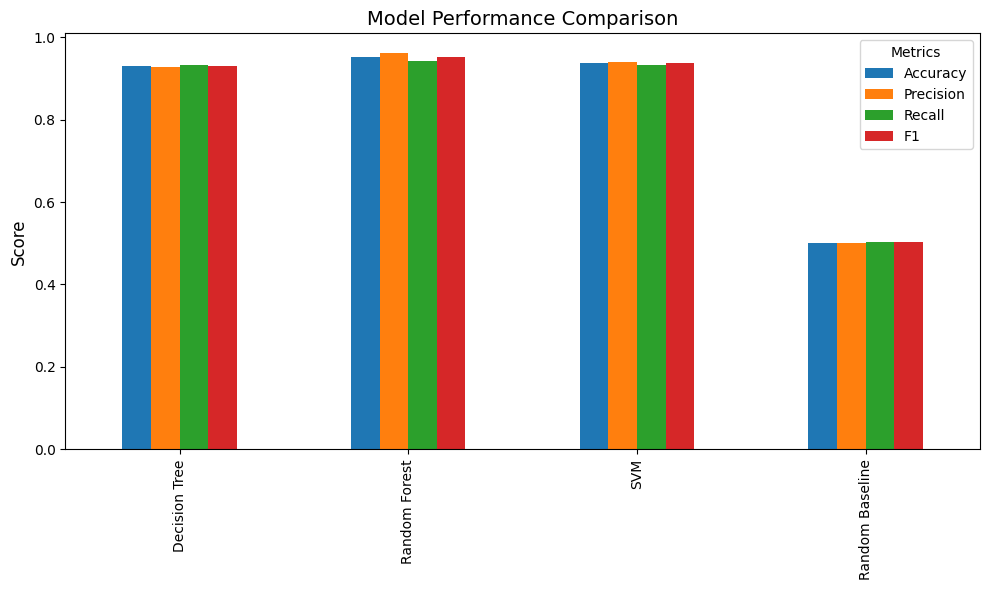

In [9]:
# Bar chart for Accuracy, Precision, Recall, F1
results_df[['Accuracy','Precision','Recall','F1']].plot(kind="bar", figsize=(10,6))

plt.title("Model Performance Comparison", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()


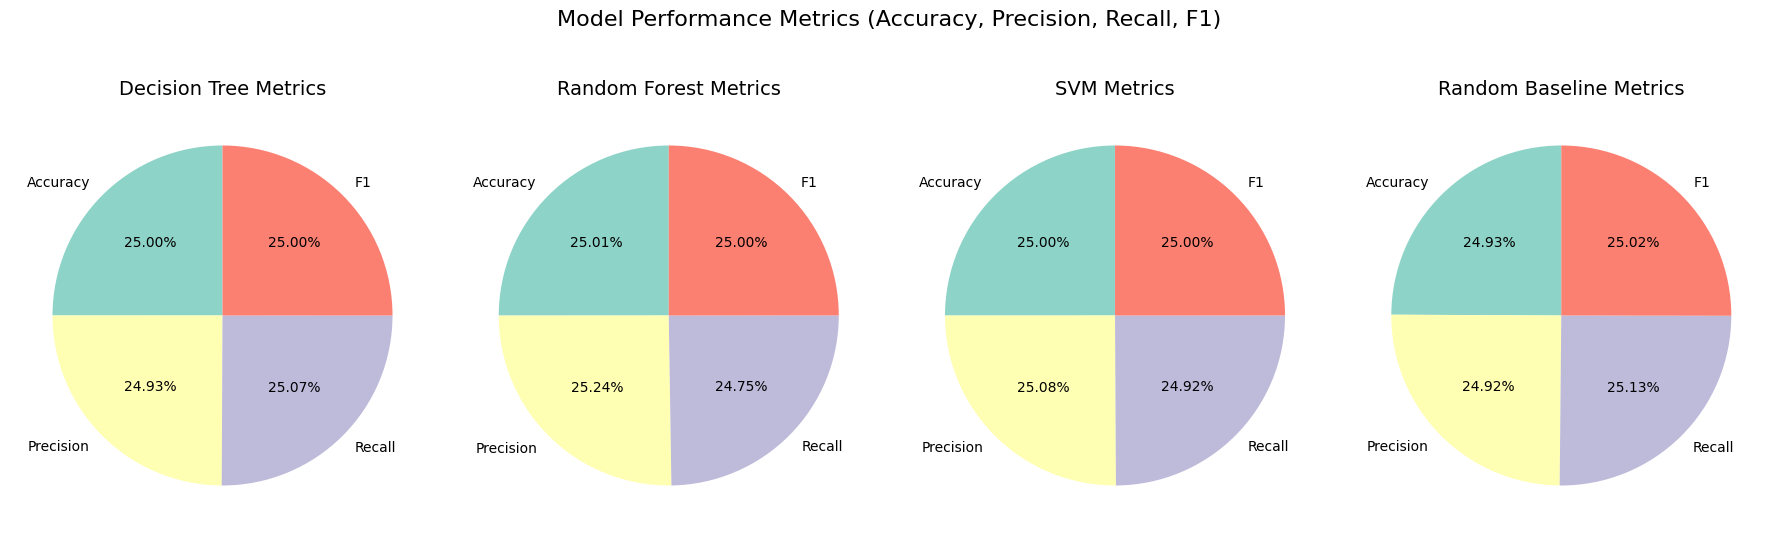

In [10]:
import matplotlib.pyplot as plt

models = results_df.index
metrics_list = ["Accuracy", "Precision", "Recall", "F1"]

# Setup subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, len(models), figsize=(18,6))

for i, model_name in enumerate(models):
    metrics = results_df.loc[model_name, metrics_list]
    
    axes[i].pie(metrics.values, 
                labels=metrics.index, 
                autopct="%1.2f%%", 
                startangle=90, 
                colors=plt.cm.Set3.colors)
    
    axes[i].set_title(f"{model_name} Metrics", fontsize=14)

plt.suptitle("Model Performance Metrics (Accuracy, Precision, Recall, F1)", fontsize=16)
plt.tight_layout()
plt.show()


In [11]:
import plotly.express as px

for model_name in results_df.index:
    metrics = results_df.loc[model_name, ["Accuracy","Precision","Recall","F1"]]
    pie_data = metrics.reset_index()
    pie_data.columns = ["Metric", "Score"]

    fig = px.pie(pie_data, names="Metric", values="Score",
                 title=f"{model_name} Performance Metrics", hole=0.3)
    fig.update_traces(textposition='inside', textinfo='percent+label')

    # Force open in browser instead of Jupyter
    import plotly.io as pio
    pio.renderers.default = "browser"
    fig.show()
